In [1]:
import os
import sys
sys.path.append("..")

import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

#from data import loader_train, loader_val, loader_test
from train import train_model, test_model
from models import getModels
from utils import show_img
from trainers import Regression, Classification, BinaryClassification
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from ResNet18 import ResNet, BasicBlock
from ResNet18Medium import ResNet18

In [2]:
from medmnist import PneumoniaMNIST, BreastMNIST, RetinaMNIST, DermaMNIST, ChestMNIST, PathMNIST

from torch.utils.data import Subset

batch_size = 32
transfomrms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
test_dataset = ChestMNIST(split="test",transform= transfomrms, download=True,size=224)
train_dataset = ChestMNIST(split="train", transform= transfomrms,download=True,size=224)
val_dataset = ChestMNIST(split="val",transform=transfomrms, download=True,size=224)

loader_train = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
# Definir el tamaño del subconjunto que deseas usar (por ejemplo, 10%)
subset_size = int(0.001 * len(train_dataset))

# Crear subconjuntos con índices aleatorios
train_indices = torch.randperm(len(train_dataset))[:subset_size]
val_indices = torch.randperm(len(val_dataset))[:subset_size*2]
test_indices = torch.randperm(len(test_dataset))[:subset_size*2]

# Crear los subconjuntos utilizando los índices seleccionados
train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

Using downloaded and verified file: C:\Users\34658\.medmnist\chestmnist_224.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\chestmnist_224.npz
Using downloaded and verified file: C:\Users\34658\.medmnist\chestmnist_224.npz


In [3]:
# start a new wandb run to track this script
import wandb
wandb.finish()
wandb.init(
    # set the wandb project where this run will be logged
    project="Test",
    name="MyComputer - Tests",

    # track hyperparameters and run metadata
    config={
        "N_images" : 1,
        "learning_rate": 0.001,
        "dataset": "Expert 1",
        "epochs": 50,
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: chermar (chermar-universitat-polit-cnica-de-val-ncia). Use `wandb login --relogin` to force relogin


In [4]:
import os
import sys
sys.path.append("..")


loader_train = DataLoader(train_subset, batch_size=32, shuffle=True)
loader_val = DataLoader(val_dataset, batch_size=32, shuffle=True)
loader_test = DataLoader(test_subset, batch_size=32, shuffle=True)

In [60]:
import lightning.pytorch as pl
import torch
import torch.nn as nn
import torchmetrics as tm
from torchmetrics.classification import MulticlassConfusionMatrix
import matplotlib.pyplot as plt
class LabelClassification(pl.LightningModule):
    """
    Trainer para entrenar un modelo de clasificación multilabel
    y de dimension N con valores [0, 1]*N
    """
    def __init__(self, model, device):
        super().__init__()
        self.save_hyperparameters(ignore=("model",))

        self.model = model

        self.loss_fn = nn.CrossEntropyLoss()

        self.confusion_matrix =  [tm.ConfusionMatrix(num_classes=2, task="binary").to(device) for _ in range(self.model.classes)] #Definir matriz de confusión para clasificación multiclase
        self.auc_metric = [tm.AUROC(num_classes=2, task="binary").to(device) for _ in range(self.model.classes)]  # Definir métrica AUROC para clasificación multiclase

    def forward(self, x):
        return self.model(x)

    def training_step(self, x, y):
        y = y.float()
        y_hat = self.model(x)

        loss = self.loss_fn(y_hat, y)
        # Calcular métricas
        loss.backward()
        
        for i in range(self.model.classes):
            self.auc_metric[i].update(y_hat[:, i], y[:, i])
            self.confusion_matrix[i].update(y_hat >= 0.5, y)
        

        precision, recall, f1_score, ACC, AUC = self.calculate_metrics_from_confusion_matrix()

        return {"loss": loss, "ACC": ACC, "recall": recall, "precision": precision, "f1_score": f1_score, "AUC": AUC}

    def validation_step(self, x, y):
        y = y.float()
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        # Obtener la clase predicha
        y_pred = torch.argmax(y_hat, dim=1)
        # Calcular métricas
        for i in range(self.model.classes):
            self.auc_metric[i].update(y_hat[:, i], y[:, i])
            y_pred = y_hat[:,i] >= 0.5
            self.confusion_matrix[i].update(y_pred, y[:, i])

        precision, recall, f1_score, ACC, AUC = self.calculate_metrics_from_confusion_matrix()

        return {"loss": loss, "ACC": ACC, "precision" : precision, "recall": recall, "f1_score" : f1_score, "AUC": AUC}

    def transform_classes(self, y):
        # Convertir las clases a un formato de one-hot encoding
        return torch.nn.functional.one_hot(y.to(torch.int64), num_classes=self.model.classes).to(float).squeeze()
    def restart_epoch(self, plot = False):
        if plot:
            self.confusion_matrix.plot()
            plt.show()
        self.confusion_matrix.reset()
        for auc_metric in self.auc_metric:
            auc_metric.reset()
    def calculate_metrics_from_confusion_matrix(self):
      confusion_matrix = self.confusion_matrix.compute()
      # Verdaderos positivos por clase (diagonal de la matriz)
      true_positives = torch.diag(confusion_matrix)

      # Predicciones totales por clase (sumar columnas)
      predicted_positives = confusion_matrix.sum(dim=0)

      # Ejemplos reales por clase (sumar filas)
      actual_positives = confusion_matrix.sum(dim=1)

      # Calcular Precision, Recall, F1 por clase
      precision = (true_positives / (predicted_positives + 1e-8)).mean()  # Añadir pequeña constante para evitar división por 0
      recall = (true_positives / (actual_positives + 1e-8)).mean()
      f1 = 2 * (precision * recall) / (precision + recall + 1e-8)

      # Calcular ACC
      ACC = true_positives.sum() / confusion_matrix.sum()
      # Calcular el AUC
      AUC_vector = [self.auc_metric[i].compute() for i in range(self.model.classes)],
      AUC = torch.mean(torch.tensor(AUC_vector))
      # Retornar las métricas
      return precision, recall, f1, ACC, AUC

    def configure_optimizers(self, learning_rate=0.001, betas=(0.9, 0.999), factor=0.1, patience=5):
        optimizer = torch.optim.Adam(self.model.parameters(),
                                     lr=learning_rate,
                                     betas=betas)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                               factor=factor,
                                                               patience=patience)
        return optimizer, scheduler


In [56]:
model = ResNet18(in_channels=1, n_classes = 14)
trainer = LabelClassification(model, device="cpu")
batch = next(iter(loader_train))
x, y = batch
y_hat = model(x)


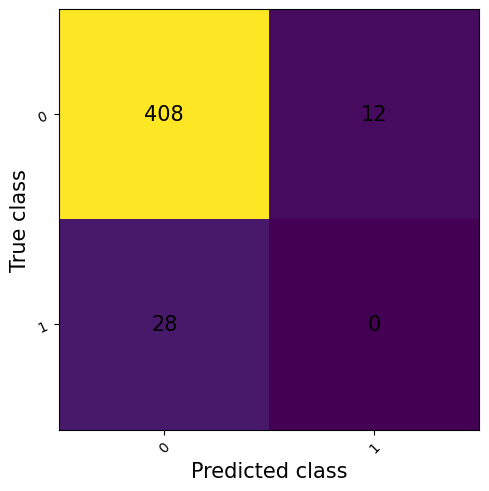

In [ ]:
cm = trainer.confusion_matrix

for i in cm:
    i.plot()
plt.show()

In [61]:
print(y.shape, y_hat.shape)
print(y[0], y_hat[0])

trainer.training_step(x, y)



torch.Size([32, 14]) torch.Size([32, 14])
tensor([0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0], dtype=torch.int32) tensor([-0.2742, -0.2494,  0.1522,  0.0201, -0.2332,  0.1749, -0.0123,  0.2700,
        -0.1715,  0.3343,  0.5654, -0.1831, -0.4061, -0.2500],
       grad_fn=<SelectBackward0>)


c:\Users\34658\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:43: UserWarning: No positive samples in targets, true positive value should be meaningless. Returning zero tensor in true positive score
  warnings.warn(*args, **kwargs)  # noqa: B028


{'loss': tensor(2.3327, grad_fn=<DivBackward1>),
 'ACC': tensor(0.9118),
 'recall': tensor(0.4863),
 'precision': tensor(0.4679),
 'f1_score': tensor(0.4769),
 'AUC': tensor(0.2505)}

In [15]:
#train a model
model =  ResNet(img_channels=1, num_layers=18, block=BasicBlock, num_classes=14)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
trainer = LabelClassification(model, device)



train_model(model, loader_train, loader_val, trainer,  device, num_epochs=1, classification = True)
test_model(model, loader_test, trainer, device, classification = True)

AttributeError: 'MulticlassConfusionMatrix' object has no attribute 'sum'

In [ ]:
test_model(model, loader_test, trainer, device, classification = True)